# Project: Wrangling and Analyze Data


### Table of Contents
* [Data Gathering ](#Data_Gathering)
* [Assessing Data ](#Assessing_Data)
    * [Visual Assessment](#Visual_Assessment)
    * [Programmatic Assessement](#Programmatic_Assessement)
    * [Quality Issues](#Quality_Issues)
    * [Tidiness Issues](#Tidiness_Issues)
* [Cleaning Data](#Cleaning_Data)
* [Storing Data](#Storing_Data)
* [Analyzing And Visualizing Data](#Analyzing_and_Visualizing_Data)
* [References](#References)

## Data Gathering <a class="anchor" id="Data_Gathering"></a>
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import pandas as pd
import requests 
import os
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import numpy as np
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Load twitter archive dataset
WeRateDogs_df = pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
# Load image_predictions dataset using requests library
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [4]:
with open('image-predictions.tsv', 'wb') as file:
    file.write(response.content)
image_prediction = pd.read_csv('image-predictions.tsv', sep='\t' )

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [ ]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = WeRateDogs_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepyException as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [5]:
df_list = []
with open('tweet-json.txt') as file:
    for line in file:
        data = json.loads(line)
        tweet_ID = data['id']
        retweet_count = data['retweet_count']
        favourite_count = data['favorite_count']
# Append to list of dictionaries
        df_list.append({'tweet_ID': tweet_ID,
                    'retweet_count': retweet_count,
                    'favourite_count': favourite_count})
tweet_json = pd.DataFrame(df_list, columns = ['tweet_ID', 'retweet_count', 'favourite_count'])

## Assessing Data<a class="anchor" id="Assessing_Data"></a>
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment, programmatic assessement to assess the data.


### Visual Assessment<a class="anchor" id="Visual_Assessment"></a>

In [6]:
tweet_json

,tweet_ID,retweet_count,favourite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


In [7]:
image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [8]:
WeRateDogs_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


## Programmatic Assessement<a class="anchor" id="Programmatic_Assessement"></a>

In [9]:
WeRateDogs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [10]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_ID           2354 non-null int64
retweet_count      2354 non-null int64
favourite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.3 KB


In [11]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [12]:
WeRateDogs_df.duplicated().sum()

0

In [13]:
tweet_json.duplicated().sum()

0

In [14]:
image_prediction.duplicated().sum()

0

In [15]:
WeRateDogs_df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [16]:
tweet_json.isnull().sum()

tweet_ID           0
retweet_count      0
favourite_count    0
dtype: int64

In [17]:
image_prediction.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [18]:
WeRateDogs_df.name.value_counts()

None       745
a           55
Charlie     12
Oliver      11
Lucy        11
          ... 
Bobbay       1
Vinnie       1
Mauve        1
Laela        1
Coleman      1
Name: name, Length: 957, dtype: int64

In [19]:
WeRateDogs_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

## Quality Issues<a class="anchor" id="Quality_Issues"></a>
WeRateDogs_df:

1.expanded_urls column has many missing values

2.There are duplicate tweets, that have been retweeted.

3.in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp columns have barely data

4.Name column has meaningless names such as a,an and such

5.The datatype of timestamp is string not Datetime

6.rating_denominator has invalid values(numbers less than 10)

image_predictions:

7.This table contains ambiguous columns names

8.img_num column is useless

tweet_json:

9.tweet_ID column name is different than other tweet id name in other tables 


## Tidiness Issues<a class="anchor" id="Tidiness_Issues"></a>
There are three requirements for tidiness
Each variable forms a column. Each observation forms a row. And each type of observational unit forms a table.So, in order to solve the dataframes tidiness issues.I'm going to:

1.Combine dog stages into one column in WeRateDogs_df dataframe

2.Combine all dataframes

## Cleaning Data<a class="anchor" id="Cleaning_Data"></a>
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [23]:
# Make copies of original pieces of data

WeRateDogs_clean = WeRateDogs_df.copy()
image_prediction_clean = image_prediction.copy()
tweet_json_clean = tweet_json.copy()

### Issue #1

#### Define:  
I'm going to drop all of the missing data in expanded_urls column using dropna()

#### Code

In [24]:
WeRateDogs_clean['expanded_urls'].dropna(inplace=True)

#### Test

In [25]:
WeRateDogs_clean['expanded_urls'].isnull().sum() 

0

### Issue #2

#### Define:  
I'm going to include the original tweets and remove the rest.

#### Code

In [49]:
WeRateDogs_clean = WeRateDogs_clean[WeRateDogs_clean.retweeted_status_id.isnull()]
WeRateDogs_clean = WeRateDogs_clean[WeRateDogs_clean.retweeted_status_user_id.isnull()]
WeRateDogs_clean = WeRateDogs_clean[WeRateDogs_clean.retweeted_status_timestamp.isnull()]

#### Test

In [50]:
WeRateDogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

### Issue #3:

#### Define
For this issue I'm going to drop in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp 

#### Code

In [51]:
WeRateDogs_clean.drop(columns=['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],inplace=True)

#### Test

In [52]:
WeRateDogs_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

### Issue #4:

#### Define 
I'm going to drop names that has meaningless words such as a,an and such

#### Code

In [53]:
#Drop stopwords 
stop_words = stopwords.words('english')
WeRateDogs_clean['name'] = WeRateDogs_clean['name'].apply(lambda x: ' '.join([word for word in  str(x).split() if word not in (stop_words)]))

In [54]:
#replace none and empty values to nan so i can drop them
WeRateDogs_clean.name.replace(to_replace=['None',''], value=np.nan, inplace=True)
WeRateDogs_clean.name.dropna(inplace=True)

#### Test

In [55]:
WeRateDogs_clean.name.isnull().sum()

0

### Issue #5:

#### Define 
I'm going to convert the datatype of timestamp column to datetime format using to_datetime function

#### Code

In [56]:
WeRateDogs_clean['timestamp'] = pd.to_datetime(WeRateDogs_clean['timestamp'])

#### Test

In [57]:
WeRateDogs_clean.timestamp.dtype

datetime64[ns, UTC]

### Issue #6:

#### Define
Some rating_denominator has rating less than or greater than 10

#### Code

In [58]:
WeRateDogs_clean.drop(index=WeRateDogs_clean[(WeRateDogs_clean.rating_denominator != 10)].index,inplace=True)

#### Test

In [59]:
WeRateDogs_clean.rating_denominator.value_counts()

10    2153
Name: rating_denominator, dtype: int64

### Issue #7: 

#### Define
This table has some unclear columns such as p and p_conf. So, I'm going to handle this issue by renaming all p columns to image prediction and p_conf to prediction confidence

#### Code

In [60]:
image_prediction_clean.rename(columns = {'p1':'image_prediction1' ,'p1_conf':'prediction_confidence1' , 'p1_dog':'dog_prediction1' ,'p2':'image_prediction2' , 'p2_conf':'prediction_confidence2'  , 'p2_dog':'dog_prediction2' , 'p3':'image_prediction3' , 'p3_conf':'prediction_confidence3', 'p3_dog':'dog_prediction3'}, inplace = True)

#### Test

In [61]:
image_prediction_clean.head()

,tweet_id,jpg_url,img_num,image_prediction1,prediction_confidence1,dog_prediction1,image_prediction2,prediction_confidence2,dog_prediction2,image_prediction3,prediction_confidence3,dog_prediction3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Issue #8:

#### Define
img_num column is useless . So I'm going to drop it since that doesn't affect the dataset

#### Code

In [62]:
image_prediction_clean.drop("img_num",inplace=True,axis=1)

#### Test

In [63]:
image_prediction_clean

,tweet_id,jpg_url,image_prediction1,prediction_confidence1,dog_prediction1,image_prediction2,prediction_confidence2,dog_prediction2,image_prediction3,prediction_confidence3,dog_prediction3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


### Issue #9:

#### Define
I'm going to rename the tweet_ID column to tweet_id

#### Code

In [64]:
tweet_json_clean.rename(columns={"tweet_ID": "tweet_id"}, inplace=True)

#### Test

In [65]:
tweet_json_clean.columns

Index(['tweet_id', 'retweet_count', 'favourite_count'], dtype='object')

### Issue #9:

#### Define
Combine dog stages into one column in WeRateDogs_df dataframe

#### Code

In [66]:
#make new column to join the extracted dog stages
dogs_stages = ['doggo', 'floofer', 'pupper', 'puppo']
WeRateDogs_clean['dogs_stage'] = WeRateDogs_clean.text.str.extract('({})'.format('|'.join(dogs_stages)), expand=True)

In [67]:
#replce empty values to null and drop them
WeRateDogs_clean.dogs_stage.replace(to_replace=[''], value=np.nan, inplace=True)

In [68]:
#Drop unjoined columns
WeRateDogs_clean = WeRateDogs_clean.drop(dogs_stages, axis=1)

#### Test

In [69]:
WeRateDogs_clean.dogs_stage.value_counts()

pupper     238
doggo       83
puppo       32
floofer      4
Name: dogs_stage, dtype: int64

### Issue #11:

#### Define
I'm going to combine three dataframes

#### Code

In [70]:
Merged_dfs = pd.merge(pd.merge(WeRateDogs_clean,image_prediction_clean,on='tweet_id'),tweet_json_clean,on='tweet_id')

#### Test

In [71]:
Merged_dfs.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dogs_stage',
       'jpg_url', 'image_prediction1', 'prediction_confidence1',
       'dog_prediction1', 'image_prediction2', 'prediction_confidence2',
       'dog_prediction2', 'image_prediction3', 'prediction_confidence3',
       'dog_prediction3', 'retweet_count', 'favourite_count'],
      dtype='object')

## Storing Data<a class="anchor" id="Storing_Data"></a>
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [72]:
Merged_dfs.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data<a class="anchor" id="Analyzing_and_Visualizing_Data"></a>

**In this section, I'm going to discover these insights:**

1-Find the most popular dog name in the dataset 

2-Find the most popular dog stage in the dataset

3-Which year was the account most active


In [73]:
Merged_dfs.name.value_counts().head(1)

Charlie    11
Name: name, dtype: int64

Text(0.5, 1.0, 'The Most Popular Dog Stages ')

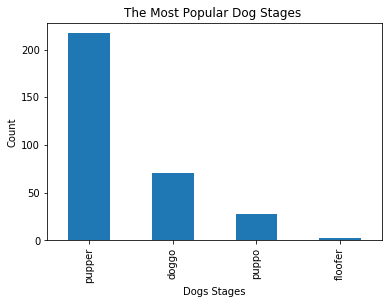

In [74]:
Merged_dfs.dogs_stage.value_counts().plot(kind="bar")
plt.xlabel("Dogs Stages")
plt.ylabel("Count")
plt.title("The Most Popular Dog Stages ")

In [75]:
Years=Merged_dfs['timestamp'].dt.year 
Years.value_counts()

2016    960
2015    660
2017    356
Name: timestamp, dtype: int64

### Insights:
1.11 Dogs named Charlie which make it the most repeated name and the popular name in the dataset

2.Pupper is the most popular dog stage in the dataset as shown above in the bar char

3.2016 was the most active year among the rest years 

## References<a class="anchor" id="References"></a>

1-Udacity Knowledge

2-https://www.geeksforgeeks.org/get-the-substring-of-the-column-in-pandas-python/

3-https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

4-https://stackoverflow.com/questions/46921465/extract-substring-from-text-in-a-pandas-dataframe-as-new-column